In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from tools import EarlyStopping

import matplotlib.pyplot as plt
import numpy as np
import math

In [2]:
num_classes = 4
learning_rate = 0.001
num_epochs = 20
batch_size = 20

In [3]:
data_transforms = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)])
img = torchvision.datasets.ImageFolder(root='COVID-19_Radiography_Dataset', transform=data_transforms)
train_size = math.floor(len(img)*0.7)
val_size = math.floor(len(img)*0.2)
train_d, validation, test = torch.utils.data.random_split(img, [train_size, val_size, len(img)-train_size-val_size])

train_loader = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(validation, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=True)

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [5]:
class CNN(nn.Module):
  def __init__(self , num_classes=10):
    super(CNN, self).__init__()
    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=2) ,
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      # nn.Dropout(0.25))
    self.layer2 = nn.Sequential(
      nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2) ,
      nn.BatchNorm2d(32),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      # nn.Dropout(0.25))
    self.layer3 = nn.Sequential(
      nn.Conv2d(32, 64, kernel_size=7, stride=1, padding=3) ,
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      # nn.Dropout(0.25))
    self.layer4 = nn.Sequential(
      nn.Conv2d(64, 128, kernel_size=11, stride=1, padding=5) ,
      nn.BatchNorm2d(128),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2))
      # nn.Dropout(0.25))
    self.fc = nn.Linear(18*18*128 , num_classes)
    
  def forward(self , x):
    # print("Entro layer 1")
    out = self.layer1(x)
    # print("Paso layer 1")
    out = self.layer2(out)
    # print("Paso layer 2")
    out = self.layer3(out)
    # print("Paso layer 3")
    out = self.layer4(out)
    # print("Paso layer 4")
    out = out.reshape(out.size(0) , -1)
    # print("Reshapeo")
    out = self.fc(out)
    return out

In [6]:
def train(model, optimizer, loss_fn, num_epochs, patience):
  # train the model
  total_step = len(train_loader)

  list_loss= []
  list_val = []
  avg_list_loss = []
  avg_list_val = []

  earlyStopping = EarlyStopping(patience=patience, verbose=False)

  for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)
      # change the params
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      list_loss.append(loss.item())
              
      if (i+1) % 100 == 0:
              print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                    .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    avg_list_loss.append(np.mean(list_loss))

    for i, (images, labels) in enumerate(val_loader):
      images = images.to(device)
      labels = labels.to(device)
      # forward 
      output = model(images)
      loss   = loss_fn(output, labels)

      list_val.append(loss.item())
              
    avg_list_val.append(np.mean(list_val))
    
    list_loss = []
    list_val = []

    earlyStopping(avg_list_val[-1], model)
    if earlyStopping.early_stop:
      print("Early stopping")
      break
    
  print('Finished Training Trainset')
  return avg_list_loss, avg_list_val


In [7]:
model         = CNN(num_classes).to(device)
loss_fn       = nn.CrossEntropyLoss()
optimizer     = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [8]:
avg_list_loss, avg_list_val = train(model, optimizer, loss_fn, 20, 5)

Epoch [1/20], Step [100/741], Loss: 0.7453
Epoch [1/20], Step [200/741], Loss: 0.9185
Epoch [1/20], Step [300/741], Loss: 0.7535
Epoch [1/20], Step [400/741], Loss: 0.4859
Epoch [1/20], Step [500/741], Loss: 0.5228
Epoch [1/20], Step [600/741], Loss: 0.4898
Epoch [1/20], Step [700/741], Loss: 0.3814
Epoch [2/20], Step [100/741], Loss: 0.2802
Epoch [2/20], Step [200/741], Loss: 0.1940
Epoch [2/20], Step [300/741], Loss: 0.3535
Epoch [2/20], Step [400/741], Loss: 0.2771
Epoch [2/20], Step [500/741], Loss: 0.5830
Epoch [2/20], Step [600/741], Loss: 0.2286
Epoch [2/20], Step [700/741], Loss: 0.2649
Epoch [3/20], Step [100/741], Loss: 0.4064
Epoch [3/20], Step [200/741], Loss: 0.3368
Epoch [3/20], Step [300/741], Loss: 0.1260
Epoch [3/20], Step [400/741], Loss: 0.4903
Epoch [3/20], Step [500/741], Loss: 0.5170
Epoch [3/20], Step [600/741], Loss: 0.2973
Epoch [3/20], Step [700/741], Loss: 0.0444
Epoch [4/20], Step [100/741], Loss: 0.0983
Epoch [4/20], Step [200/741], Loss: 0.0720
Epoch [4/20

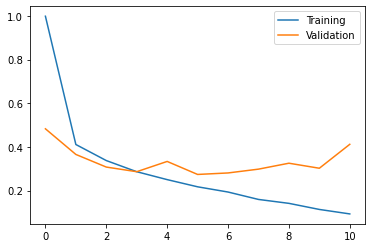

In [9]:
plt.plot([i for i in range(len(avg_list_loss))], avg_list_loss)
plt.plot([i for i in range(len(avg_list_val))], avg_list_val)
plt.legend(['Training', 'Validation'])

In [10]:
print(avg_list_loss)
print(avg_list_val)

[0.998226239734333, 0.41094353687465596, 0.3373733864551694, 0.2863290604711705, 0.2501258475821611, 0.2172398349023883, 0.19328641767805887, 0.15937483384476298, 0.14145191677427485, 0.11355948812603528, 0.09308408046164518]
[0.4828133984416161, 0.365445331266185, 0.30759843444135393, 0.28636860863288055, 0.3333890252342483, 0.2738142923258667, 0.28065702977221246, 0.2981052082119826, 0.3252512203081388, 0.30222636866295394, 0.41182291562084705]


In [11]:
def testAccuracy():
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        print('Test Accuracy of the model: {} %'.format(100 * correct / total))


In [12]:
testAccuracy()

Test Accuracy of the model on the 10000 test images: 89.04109589041096 %
